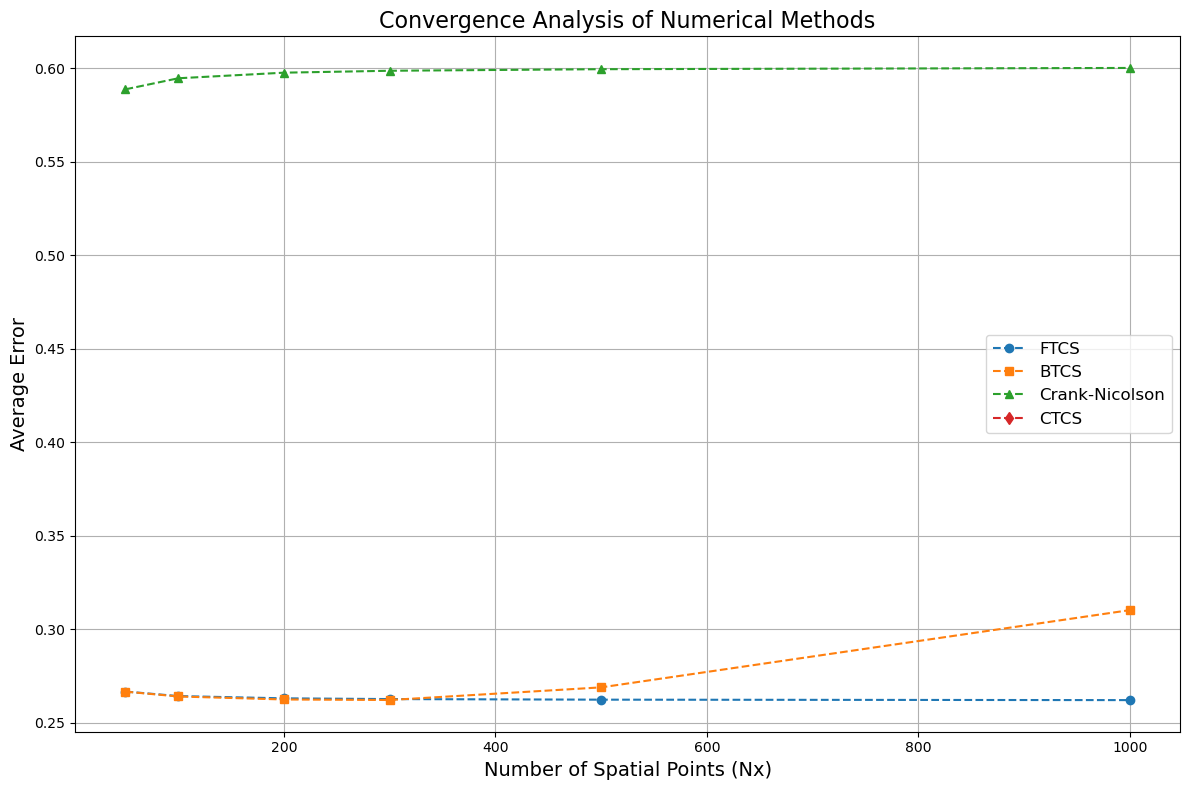

Convergence results saved to 'heat_equation_convergence_analysis.xlsx'.


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import splu

# Define parameters
L = 1.0          # Length of the domain
T = 0.1         # Total simulation time
Nt = 500000        # Number of time steps
alpha = 1.0      # Thermal diffusivity
dt = T / Nt      # Time step size

# Function for the reference solution (analytical or highly accurate)
def reference_solution(x, t, L=1.0, alpha=1.0):
    return 1 - (1 - np.exp(-alpha * np.pi**2 * t / L**2)) * np.sin(np.pi * x)

# FTCS method with explicit time-stepping
def solve_ftcs_lu(Nx, dx):
    r = alpha * dt / dx**2
    x = np.linspace(0, L, Nx)
    u_initial = np.zeros(Nx)
    u_initial[0] = 1  # Boundary condition at x=0 at t=0
    u_initial[-1] = 0  # Boundary condition at x=L at t=0

    u = u_initial.copy()
    for n in range(1, Nt):
        u_new = u + r * (np.roll(u, -1) - 2*u + np.roll(u, 1))  # Explicit update
        u_new[0] = 1  # Boundary condition at x=0
        u_new[-1] = 0  # Boundary condition at x=L
        u = u_new
    return u

# BTCS method using LU decomposition (sparse)
def solve_btcs_lu(Nx, dx):
    r = alpha * dt / dx**2
    x = np.linspace(0, L, Nx)
    u_initial = np.zeros(Nx)
    u_initial[0] = 1  # Boundary condition at x=0 at t=0
    u_initial[-1] = 0  # Boundary condition at x=L at t=0

    diagonal_btcs = (1 + 2 * r) * np.ones(Nx)
    off_diagonal_btcs = -r * np.ones(Nx - 1)
    A_btcs = diags([off_diagonal_btcs, diagonal_btcs, off_diagonal_btcs], offsets=[-1, 0, 1], shape=(Nx, Nx)).tocsc()
    lu_btcs = splu(A_btcs)

    u = u_initial.copy()
    for n in range(1, Nt):
        b = u.copy()
        b[0] = 1  # Boundary condition at x=0
        b[-1] = 0  # Boundary condition at x=L
        u = lu_btcs.solve(b)
    return u

# Crank-Nicolson method using LU decomposition (sparse)
def solve_crank_nicolson_lu(Nx, dx):
    r = alpha * dt / dx**2
    x = np.linspace(0, L, Nx)
    u_initial = np.zeros(Nx)
    u_initial[0] = 1  # Boundary condition at x=0 at t=0
    u_initial[-1] = 0  # Boundary condition at x=L at t=0

    diagonal_cn = (1 + r) * np.ones(Nx)
    off_diagonal_cn = -r / 2 * np.ones(Nx - 1)
    A_cn = diags([off_diagonal_cn, diagonal_cn, off_diagonal_cn], offsets=[-1, 0, 1], shape=(Nx, Nx)).tocsc()
    B_cn = diags([off_diagonal_cn, 1 - r, off_diagonal_cn], offsets=[-1, 0, 1], shape=(Nx, Nx)).tocsc()
    lu_cn = splu(A_cn)

    u = u_initial.copy()
    for n in range(1, Nt):
        b = B_cn @ u
        b[0] = 1  # Boundary condition at x=0
        b[-1] = 0  # Boundary condition at x=L
        u = lu_cn.solve(b)
    return u

# CTCS method using sparse matrix multiplication
def solve_ctcs_sparse(Nx, dx):
    r = alpha * dt / dx**2
    x = np.linspace(0, L, Nx)
    u_initial = np.zeros(Nx)
    u_initial[0] = 1  # Boundary condition at x=0 at t=0
    u_initial[-1] = 0  # Boundary condition at x=L at t=0

    diagonal_ctcs = -2 * np.ones(Nx)
    off_diagonal_ctcs = np.ones(Nx - 1)
    A_ctcs = diags([off_diagonal_ctcs, diagonal_ctcs, off_diagonal_ctcs], offsets=[-1, 0, 1], shape=(Nx, Nx)).tocsc()

    u_prev = u_initial.copy()  # u^{n-1}
    u_curr = u_initial.copy()  # u^n
    u_next = u_initial.copy()  # u^{n+1}

    # First time step using FTCS
    for i in range(1, Nx-1):
        u_next[i] = u_curr[i] + r * (u_curr[i+1] - 2*u_curr[i] + u_curr[i-1])
    u_next[0] = 1  # Boundary condition at x=0
    u_next[-1] = 0  # Boundary condition at x=L

    u_prev = u_curr.copy()
    u_curr = u_next.copy()

    # Main CTCS loop
    for n in range(2, Nt):
        u_next = u_prev + 2 * r * (A_ctcs @ u_curr)  # Sparse matrix multiplication
        u_next[0] = 1  # Boundary condition at x=0
        u_next[-1] = 0  # Boundary condition at x=L
        u_prev = u_curr.copy()
        u_curr = u_next.copy()

    return u_curr

# Function to compute errors (comparison against a finer grid reference solution)
def compute_error(u_numerical, Nx_ref, T):
    # Reference solution
    x_ref = np.linspace(0, L, Nx_ref)
    u_reference = reference_solution(x_ref, T)
    
    # Interpolate the reference solution to the finer grid (Nx)
    u_reference_interp = np.interp(np.linspace(0, L, Nx), x_ref, u_reference)
    
    # Compute the error
    error = np.abs(u_numerical - u_reference_interp)
    
    return error

# Test for different grid sizes and analyze convergence
Nx_values = [50, 100, 200 , 300 , 500 , 1000]
errors_ftcs = []
errors_btcs = []
errors_crank_nicolson = []
errors_ctcs = []

for Nx in Nx_values:
    dx = L / (Nx - 1)  # Calculate dx for each Nx
    
    # Solve for each method
    u_ftcs = solve_ftcs_lu(Nx, dx)
    u_btcs = solve_btcs_lu(Nx, dx)
    u_crank_nicolson = solve_crank_nicolson_lu(Nx, dx)
    u_ctcs = solve_ctcs_sparse(Nx, dx)
    
    # Compute errors
    error_ftcs = compute_error(u_ftcs, 200, T)
    error_btcs = compute_error(u_btcs, 200, T)
    error_crank_nicolson = compute_error(u_crank_nicolson, 200, T)
    error_ctcs = compute_error(u_ctcs, 200, T)
    
    errors_ftcs.append(np.mean(error_ftcs))
    errors_btcs.append(np.mean(error_btcs))
    errors_crank_nicolson.append(np.mean(error_crank_nicolson))
    errors_ctcs.append(np.mean(error_ctcs))

# Plot error convergence
plt.figure(figsize=(12, 8))
plt.plot(Nx_values, errors_ftcs, label='FTCS', linestyle='--', marker='o', color='tab:blue')
plt.plot(Nx_values, errors_btcs, label='BTCS', linestyle='--', marker='s', color='tab:orange')
plt.plot(Nx_values, errors_crank_nicolson, label='Crank-Nicolson', linestyle='--', marker='^', color='tab:green')
plt.plot(Nx_values, errors_ctcs, label='CTCS', linestyle='--', marker='d', color='tab:red')
plt.xlabel('Number of Spatial Points (Nx)', fontsize=14)
plt.ylabel('Average Error', fontsize=14)
plt.title('Convergence Analysis of Numerical Methods', fontsize=16)
plt.legend(loc='best', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Save results to Excel
df = pd.DataFrame({
    'Nx': Nx_values,
    'Error_FTCS': errors_ftcs,
    'Error_BTCS': errors_btcs,
    'Error_Crank_Nicolson': errors_crank_nicolson,
    'Error_CTCS': errors_ctcs
})
df.to_excel('heat_equation_convergence_analysis.xlsx', index=False)

print("Convergence results saved to 'heat_equation_convergence_analysis.xlsx'.")
